<a href="https://colab.research.google.com/github/billk97/Machine-Lerning-Project/blob/master/SPARK-BIG-DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!ls -la


total 217524
drwxr-xr-x  1 root root      4096 Dec  4 19:32 .
drwxr-xr-x  1 root root      4096 Dec  4 18:50 ..
drwxr-xr-x  2 root root      4096 Dec  4 19:09 all_qube
-rw-r--r--  1 root root    210300 Dec  4 19:00 BORROWERS.TXT
drwxr-xr-x  1 root root      4096 Dec  2 22:04 .config
drwxr-xr-x  2 root root      4096 Dec  4 19:09 department
drwxr-xr-x  2 root root      4096 Dec  4 19:09 department_gender
drwxr-xr-x  2 root root      4096 Dec  4 19:12 erotima2
drwxr-xr-x  2 root root      4096 Dec  4 19:09 gender
drwxr-xr-x  2 root root      4096 Dec  4 19:03 .ipynb_checkpoints
drwxr-xr-x  2 root root      4096 Dec  4 19:08 loansTable
-rw-r--r--  1 root root   2550847 Dec  4 19:01 LOANS.TXT
drwxr-xr-x  1 root root      4096 Dec  2 22:04 sample_data
drwxr-xr-x 13 1000 1000      4096 Aug 28 08:10 spark-3.0.1-bin-hadoop2.7
-rw-r--r--  1 root root 219929956 Aug 28 09:25 spark-3.0.1-bin-hadoop2.7.tgz


In [63]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz.4
!pip install -q findspark
!ls -la

tar: spark-3.0.1-bin-hadoop2.7.tgz.4: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
total 217524
drwxr-xr-x  1 root root      4096 Dec  4 19:32 .
drwxr-xr-x  1 root root      4096 Dec  4 18:50 ..
drwxr-xr-x  2 root root      4096 Dec  4 19:09 all_qube
-rw-r--r--  1 root root    210300 Dec  4 19:00 BORROWERS.TXT
drwxr-xr-x  1 root root      4096 Dec  2 22:04 .config
drwxr-xr-x  2 root root      4096 Dec  4 19:09 department
drwxr-xr-x  2 root root      4096 Dec  4 19:09 department_gender
drwxr-xr-x  2 root root      4096 Dec  4 19:12 erotima2
drwxr-xr-x  2 root root      4096 Dec  4 19:09 gender
drwxr-xr-x  2 root root      4096 Dec  4 19:03 .ipynb_checkpoints
drwxr-xr-x  2 root root      4096 Dec  4 19:08 loansTable
-rw-r--r--  1 root root   2550847 Dec  4 19:01 LOANS.TXT
drwxr-xr-x  1 root root      4096 Dec  2 22:04 sample_data
drwxr-xr-x 13 1000 1000      4096 Aug 28 08:10 spark-3.0.1-bin-hadoop2.7
-rw-r--r--  1 root root 219929956 Aug 28 09:25 spa

In [64]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [65]:
import findspark
findspark.init()


In [66]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, types, HiveContext
from pyspark.sql.types import *
from pyspark.sql.functions import to_date

In [108]:
import matplotlib.pyplot as plt
import pandas as pd


In [67]:
spark = SparkSession.builder.appName("import").config("spark.some.config.option", "some-value").getOrCreate()
spark.sparkContext.setLogLevel("WARN")
sc = spark.sparkContext 

In [68]:
borrowers_txt = sc.textFile("BORROWERS.TXT")
borrowers = borrowers_txt.coalesce(1).map(lambda line: line.split("|"))
headers = borrowers.first()
borrowers = borrowers.filter(lambda line: line != headers)
borrowers = borrowers.map(lambda line: (int(line[0]), line[1], line[2]))


In [69]:
borrowers.take(5)

[(1, 'M', 'Informatics'),
 (2, 'M', 'Low'),
 (3, 'M', 'BusinessAdministration'),
 (5, 'M', 'Mathematics'),
 (6, 'M', 'Low')]

In [70]:
borrowers_schema = StructType([
    StructField(headers[0], IntegerType(), True),
    StructField(headers[1], StringType(), True),
    StructField(headers[2], StringType(), True)
])

In [71]:
borrowers_DF = spark.createDataFrame(borrowers, borrowers_schema)
borrowers_DF.createOrReplaceTempView("borrowersTable")
query = spark.sql("""SELECT * FROM borrowersTable """)
query.show(3)
# query.write.format("csv").save("borrowersTable")

+---+------+--------------------+
|bid|gender|          department|
+---+------+--------------------+
|  1|     M|         Informatics|
|  2|     M|                 Low|
|  3|     M|BusinessAdministr...|
+---+------+--------------------+
only showing top 3 rows



### IMPORTING LOANS



In [72]:
loans_txt = sc.textFile("LOANS.TXT")
loans = loans_txt.coalesce(1).map(lambda line: line.split("|"))
headers = loans.first()
loans = loans.filter(lambda line: line != headers)
loans = loans.map(lambda line: (int(line[0]),line[1],int(line[2]),line[3]))

In [73]:
loans.take(3)

[(221, '44263', 339, '1995-02-28'),
 (9959, '42040', 576, '1995-02-28'),
 (1228, '45000', 167, '1995-02-28')]

In [74]:
loans_schema = StructType([
    StructField(headers[0], IntegerType(), True),
    StructField(headers[1], StringType(), True),
    StructField(headers[2], IntegerType(), True),
    StructField(headers[3], StringType(), True)
])

In [78]:
loans_DF = spark.createDataFrame(loans, loans_schema)
loans_DF.select(to_date(loans_DF.date_key, "yyyy-MM-dd").alias("date_key")).collect()
loans_DF.createOrReplaceTempView("loansTable")
query = spark.sql("""SELECT * FROM loansTable""")
query.show(3)
# query.write.format("csv").save("loansTable")

+-----+------+---+----------+
|bibno|copyno|bid|  date_key|
+-----+------+---+----------+
|  221| 44263|339|1995-02-28|
| 9959| 42040|576|1995-02-28|
| 1228| 45000|167|1995-02-28|
+-----+------+---+----------+
only showing top 3 rows



In [79]:
loans_DF.show(2)

+-----+------+---+----------+
|bibno|copyno|bid|  date_key|
+-----+------+---+----------+
|  221| 44263|339|1995-02-28|
| 9959| 42040|576|1995-02-28|
+-----+------+---+----------+
only showing top 2 rows



In [93]:
bt = borrowers_DF.alias("bt")
lt = loans_DF.alias("lt")
# join = bt.join(lt, bt.bid == lt.bid) this will have 2 rows wit bid
join = bt.join(lt, "bid")
join.createOrReplaceTempView("join")


In [94]:
qube_all = spark.sql("SELECT department, gender, COUNT(bid) as bid_count FROM join  GROUP BY GROUPING SETS((department, gender), (department), (gender), ())")
qube_all = qube_all.coalesce(1)
qube_all.show(30)
# qube_all.write.format("csv").save("all_qube")

+--------------------+------+---------+
|          department|gender|bid_count|
+--------------------+------+---------+
|             Physics|  null|     8411|
|             Biology|     M|      917|
|          Statistics|     F|     2065|
|            Medicine|     M|     1570|
|          Psychology|     F|     2636|
|          Psychology|  null|     3756|
|BusinessAdministr...|     M|     3625|
|           Economics|  null|    16665|
|                null|     F|    47930|
|                null|  null|    91640|
|BusinessAdministr...|  null|     7857|
|            Medicine|  null|     4013|
|                null|     M|    43710|
|           Economics|     M|     8714|
|         Mathematics|  null|    21799|
|             Physics|     F|     3368|
|         Mathematics|     F|    13888|
|             Biology|     F|     1888|
|         Informatics|  null|     8667|
|          Psychology|     M|     1120|
|            Medicine|     F|     2443|
|                 Low|     F|     5847|


In [83]:
# the above sql quiry sums below commands  
qube_both = spark.sql("SELECT department, gender, COUNT(bid) FROM join GROUP BY department, gender")
qube_both = qube_both.coalesce(1)
qube_both.show(3)
# qube_both.write.format("csv").save("department_gender")

qube_dep = spark.sql("SELECT department, COUNT(bid) FROM join GROUP BY department")
qube_dep = qube_dep.coalesce(1)
# qube_dep.write.format("csv").save("department")
qube_dep.show(3)

qube_gent = spark.sql("SELECT gender, COUNT(bid) FROM join GROUP BY gender")
qube_gent = qube_gent.coalesce(1)
qube_gent.show(3)
# qube_gent.write.format("csv").save("gender")

+--------------------+------+----------+
|          department|gender|count(bid)|
+--------------------+------+----------+
|             Biology|     M|       917|
|          Statistics|     F|      2065|
|BusinessAdministr...|     M|      3625|
+--------------------+------+----------+
only showing top 3 rows

+----------+----------+
|department|count(bid)|
+----------+----------+
|       Low|     14300|
|Statistics|      3367|
|Psychology|      3756|
+----------+----------+
only showing top 3 rows

+------+----------+
|gender|count(bid)|
+------+----------+
|     F|     47930|
|     M|     43710|
+------+----------+



In [84]:
qube_all.show(10)

+--------------------+------+---------+
|          department|gender|bid_count|
+--------------------+------+---------+
|             Physics|  null|     8411|
|             Biology|     M|      917|
|          Statistics|     F|     2065|
|            Medicine|     M|     1570|
|          Psychology|     F|     2636|
|          Psychology|  null|     3756|
|BusinessAdministr...|     M|     3625|
|           Economics|  null|    16665|
|                null|     F|    47930|
|                null|  null|    91640|
+--------------------+------+---------+
only showing top 10 rows



In [85]:
t = qube_all.alias("t")
t.show(30)

+--------------------+------+---------+
|          department|gender|bid_count|
+--------------------+------+---------+
|             Physics|  null|     8411|
|             Biology|     M|      917|
|          Statistics|     F|     2065|
|            Medicine|     M|     1570|
|          Psychology|     F|     2636|
|          Psychology|  null|     3756|
|BusinessAdministr...|     M|     3625|
|           Economics|  null|    16665|
|                null|     F|    47930|
|                null|  null|    91640|
|BusinessAdministr...|  null|     7857|
|            Medicine|  null|     4013|
|                null|     M|    43710|
|           Economics|     M|     8714|
|         Mathematics|  null|    21799|
|             Physics|     F|     3368|
|         Mathematics|     F|    13888|
|             Biology|     F|     1888|
|         Informatics|  null|     8667|
|          Psychology|     M|     1120|
|            Medicine|     F|     2443|
|                 Low|     F|     5847|


In [86]:
tm = t.select("department", t.gender, t.bid_count).where(t.gender == "M")
tf = t.select("department", t.gender, t.bid_count).where(t.gender == "F")
tf = tf.withColumnRenamed("bid_count", "bid_count_F")
joined = tf.join(tm, "department")
joined = joined.select(joined.department).where("bid_count_F > bid_count")
joined.show(10)


+--------------------+
|          department|
+--------------------+
|             Biology|
|BusinessAdministr...|
|         Mathematics|
|            Medicine|
|          Psychology|
|          Statistics|
+--------------------+



In [99]:
# joined.write.format("csv").save("erotima2")
join.show(3)

+---+------+--------------------+-----+------+----------+
|bid|gender|          department|bibno|copyno|  date_key|
+---+------+--------------------+-----+------+----------+
|463|     M|BusinessAdministr...|26332| 40726|1997-11-12|
|471|     M|         Mathematics| 5418| 41750|1996-05-08|
|471|     M|         Mathematics| 5744| 22201|1996-05-08|
+---+------+--------------------+-----+------+----------+
only showing top 3 rows



In [96]:
yearly_loans = loans_DF.withColumn('year', loans_DF['date_key'].substr(0, 4))
yearly_loans = yearly_loans.drop('date_key')
yearly_loans.show(3)

+-----+------+---+----+
|bibno|copyno|bid|year|
+-----+------+---+----+
|  221| 44263|339|1995|
| 9959| 42040|576|1995|
| 1228| 45000|167|1995|
+-----+------+---+----+
only showing top 3 rows



In [101]:
yearly_loans.createOrReplaceTempView("yearly_loans")

In [103]:
qube_year = spark.sql("SELECT year, COUNT(bid) FROM yearly_loans GROUP BY year")
qube_year = qube_year.coalesce(1)
qube_year.sort("year").show()

+----+----------+
|year|count(bid)|
+----+----------+
|1995|      1995|
|1996|      3180|
|1997|      3979|
|1998|      4969|
|1999|      6593|
|2000|      7462|
|2001|     11532|
|2002|     11799|
|2003|     11904|
|2004|     13362|
|2005|     11389|
|2006|      3476|
+----+----------+



In [107]:
qube_year.write.format("csv").save("erotima3")

In [138]:
df = pd.read_csv ('erotima3/erotima3.csv')
df.columns = ['years', 'loans']
df = df.sort_values(['years'])
print(df)

    years  loans
2    1995   1995
7    1996   3180
6    1997   3979
8    1998   4969
5    1999   6593
0    2000   7462
9    2001  11532
1    2002  11799
10   2003  11904
4    2004  13362
3    2006   3476


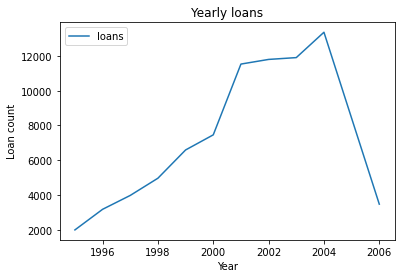

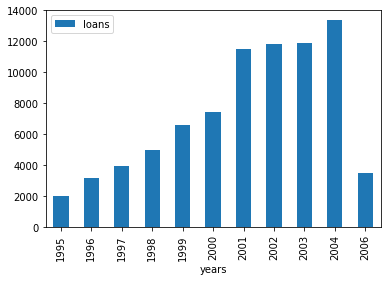

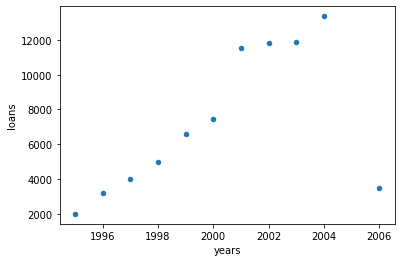

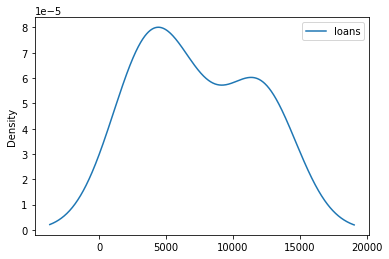

In [146]:
diagram = df.plot(title='Yearly loans', x='years', y='loans')
diagram.set_xlabel("Year")
diagram.set_ylabel("Loan count")

df.plot(kind='bar', x='years', y='loans')
df.plot.scatter( x='years', y='loans')

In [127]:
print(diagram)

AxesSubplot(0.125,0.125;0.775x0.755)
